In [259]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import OPTICS
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

## Data creation

In [260]:
#loading accident data
accidents1 = pd.read_csv('accidents_2005_to_2007.csv') #we have data from 3 different time periods
accidents2 = pd.read_csv('accidents_2009_to_2011.csv')
accidents3 = pd.read_csv('accidents_2012_to_2014.csv')
total_accidents = pd.concat([accidents1, accidents2, accidents3]) # combining data
locations = total_accidents[['Longitude', 'Latitude']] #selecting appropriate columns
locations = locations.dropna() #dropping missing values
print(locations.head()) #show data

#loading traffic flow data
aadf =  pd.read_csv('dft_traffic_counts_aadf.csv')
aadf = aadf[['longitude', 'latitude', 'all_motor_vehicles']] #selecting longitude, latitude and traffic flow
aadf = aadf.dropna()
print(aadf.head())

C:\Users\Matthijs\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


   Longitude   Latitude
0  -0.191170  51.489096
1  -0.211708  51.520075
2  -0.206458  51.525301
3  -0.173862  51.482442
4  -0.156618  51.495752
   longitude   latitude  all_motor_vehicles
0  -6.317073  49.915021                1164
1  -6.302848  49.912239                 709
2  -6.306114  49.917139                1342
3  -6.298996  49.917809                 745
4  -6.295093  49.918583                 384


In [261]:
#preprocessing data
locations = np.round(locations, decimals=2) #round coordinates to 2 decimal places
locations = locations.groupby(['Longitude', 'Latitude']).size().reset_index(name='counts') #group same coordinates together
print(locations.head()) #show data

aadf = np.round(aadf, decimals=2)
aadf = aadf.groupby(['longitude', 'latitude']).agg('mean').reset_index() #group same coordiantes together, taking the mean of their traffic flows
print(aadf.head())

   Longitude  Latitude  counts
0      -7.52     56.97       2
1      -7.51     56.99       3
2      -7.50     56.93       1
3      -7.50     56.96       2
4      -7.49     56.96       1
   longitude  latitude  all_motor_vehicles
0      -7.51     56.98          466.000000
1      -7.44     57.59          687.095238
2      -7.43     56.97          521.750000
3      -7.43     56.98          595.833333
4      -7.42     56.97          480.812500


<IPython.core.display.Javascript object>


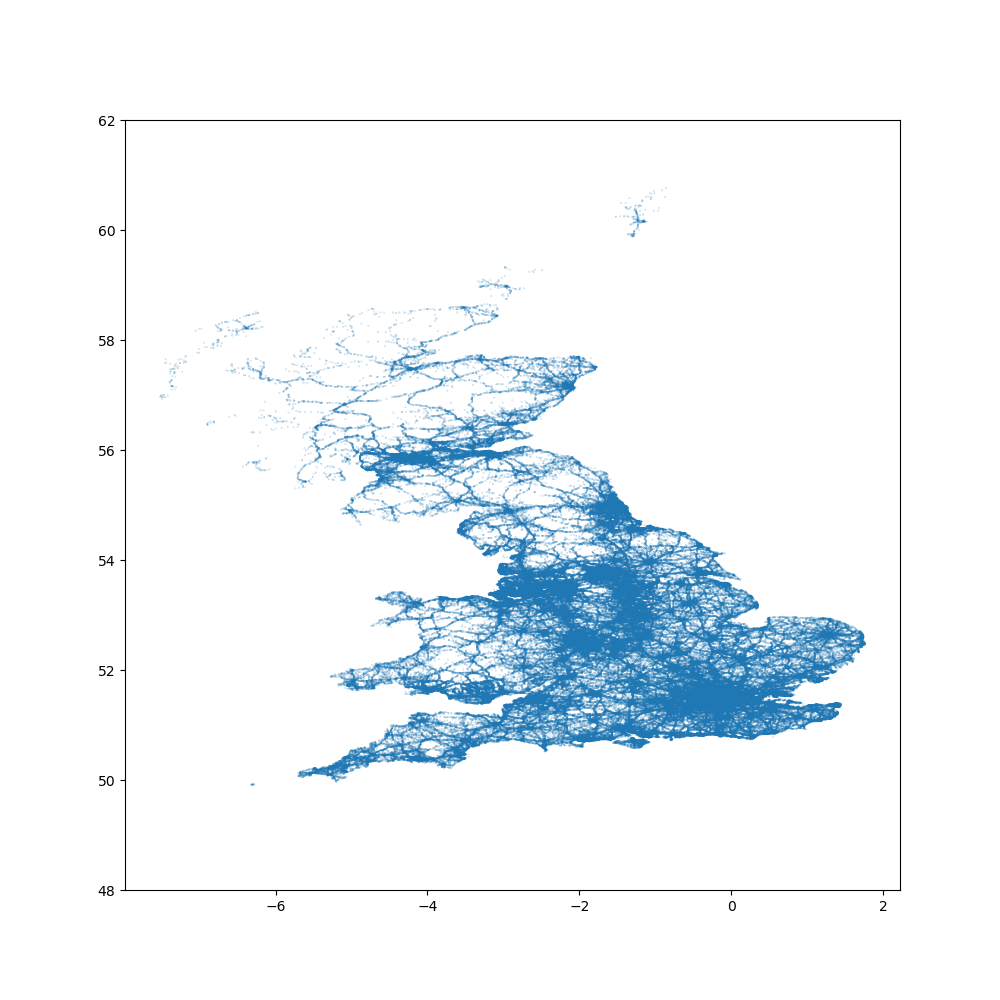

In [268]:
#location plot
%matplotlib notebook
location_plot = plt.figure(figsize  = (10,10))
plt.scatter(locations['Longitude'], locations['Latitude'], s=locations['counts']/100)
plt.ylim((48,62))
plt.show()

<IPython.core.display.Javascript object>


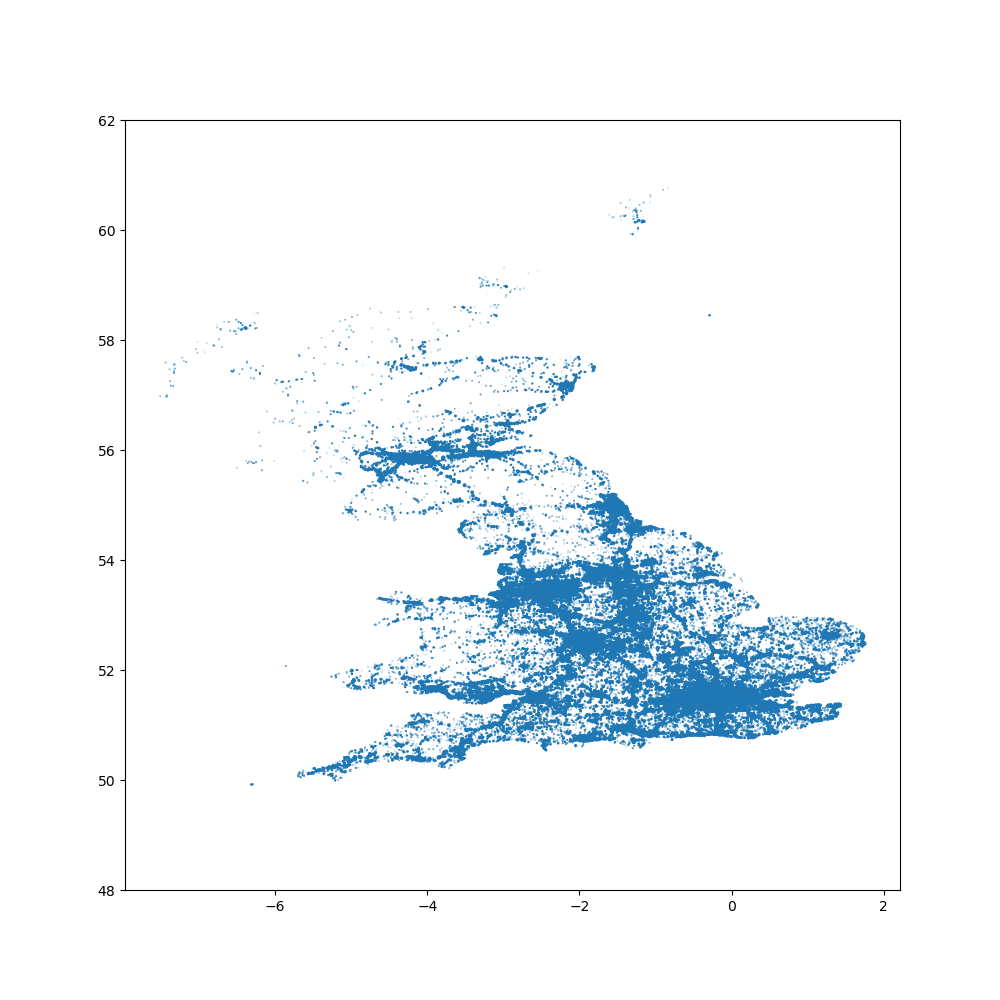

In [269]:
#aadf plot
%matplotlib notebook
aadf_plot = plt.figure(figsize  = (10,10))
plt.scatter(aadf['longitude'], aadf['latitude'], s=aadf['all_motor_vehicles']/10000)
plt.ylim((48,62))
plt.show()

## Combining the data

In [264]:
#this cell takes about a minute to run
weights = np.full(len(rounded_locations), 0.0) 
mindists = np.full(len(rounded_locations), 10000.0)

for i in range(len(aadf)): #for each location where traffic flow was measured
    weight = aadf.loc[i][2] #traffic flow of location
    dists = np.linalg.norm(list(aadf.loc[i][:2])-rounded_locations.values[:,0:2], axis=1) #distance of measure location to all accident locations
    weights[dists<mindists] = weight #assign traffic flow to close accident locations
    mindists[dists<mindists] = dists[dists<mindists] #remember distance to closest traffic flow measurement
weights[weights==0] = 0.5 #some weights are zero which is not great when dividing, so we set them to 0.5

In [265]:
locations['weight'] = weights #add traffic flow column to accidents
locations.head() #show data

,Longitude,Latitude,counts,weight
0,-7.52,56.97,2,466.0
1,-7.51,56.99,3,466.0
2,-7.50,56.93,1,466.0
3,-7.50,56.96,2,466.0
4,-7.49,56.96,1,466.0


## DBSCAN

In [266]:
db = DBSCAN(eps=0.1, min_samples=10).fit(locations.values[:,0:2], sample_weight=locations['counts']/locations['weight'])


<IPython.core.display.Javascript object>


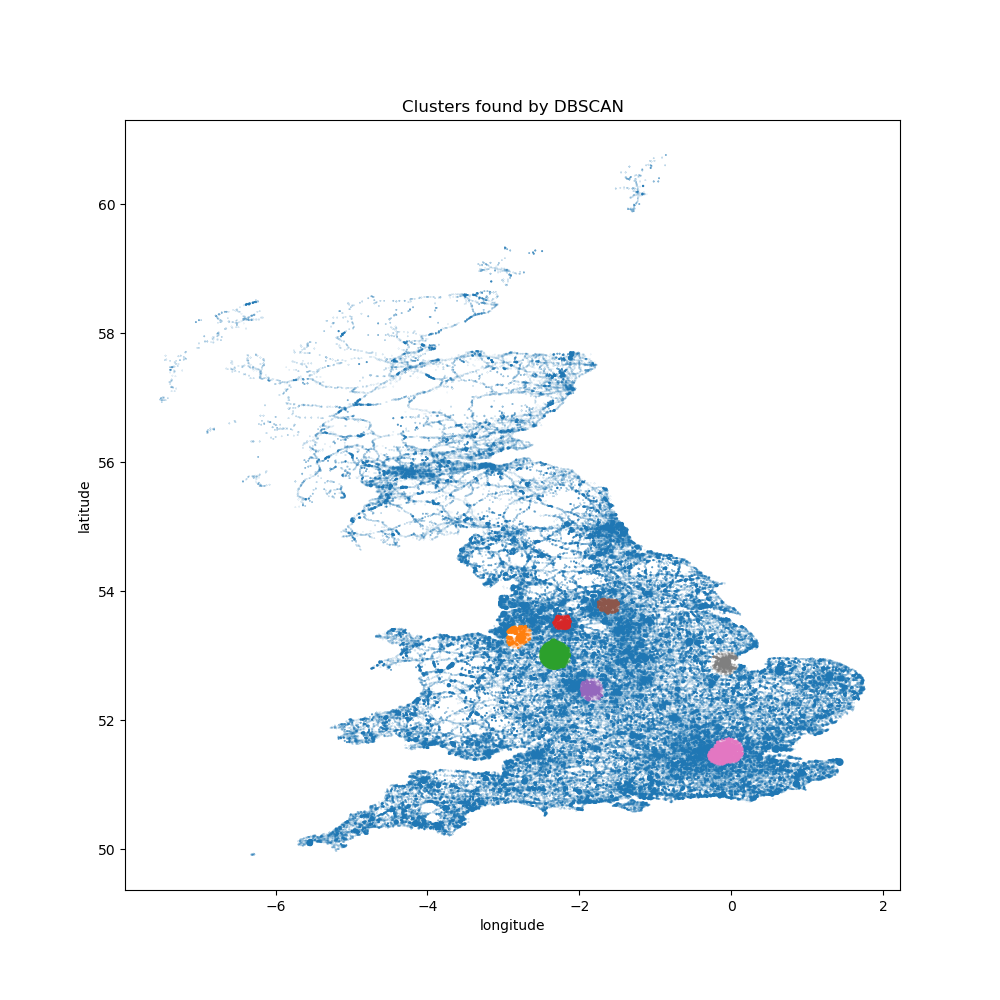

In [267]:
%matplotlib notebook
#plot results
fig = plt.figure(figsize=(10,10))
for i in sorted(list(set(db.labels_))):
    points = locations[db.labels_==i]
    plt.scatter(points['Longitude'], points['Latitude'], s=points['counts']/points['weight']*10)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Clusters found by DBSCAN')
plt.show()

## Kmeans-DB

In [248]:
km = KMeans(n_clusters=100)
km.fit(locations[['Longitude', 'Latitude']], sample_weight=locations['counts']/locations['weight'])

KMeans(n_clusters=100)

<IPython.core.display.Javascript object>


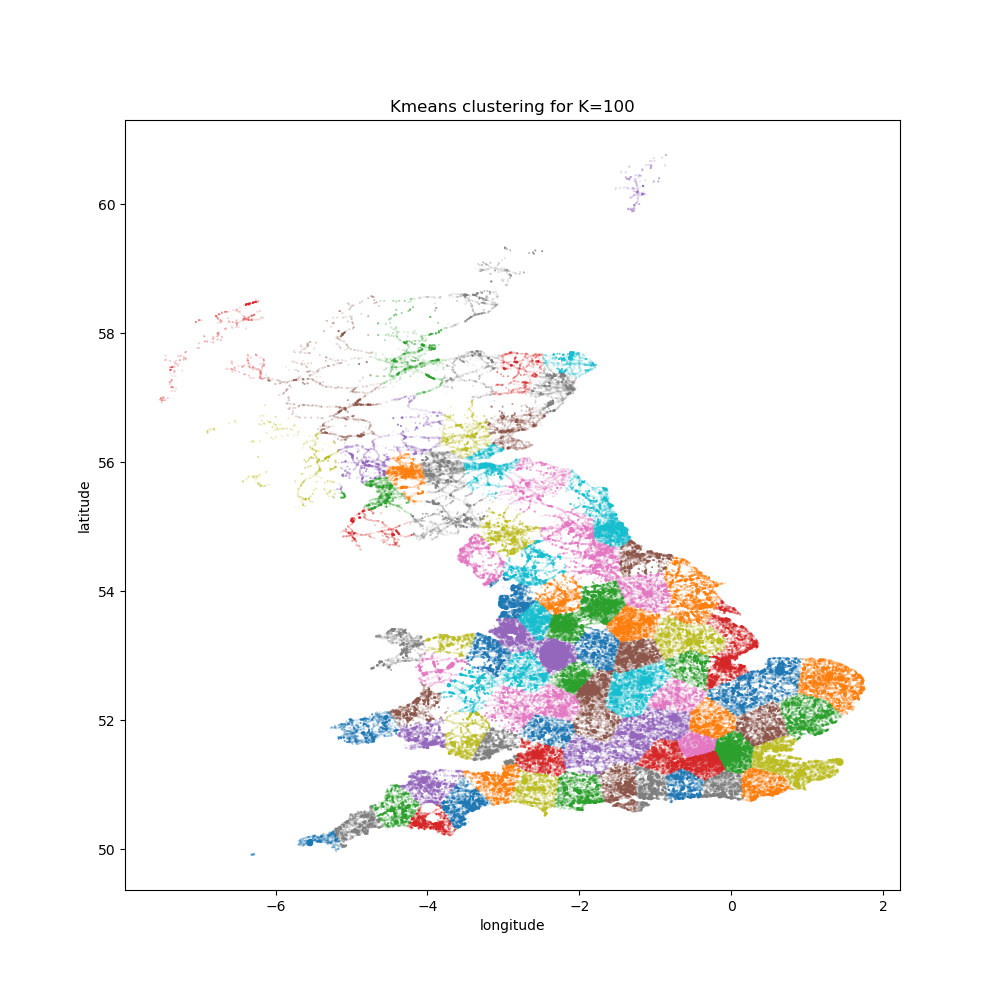

In [255]:
#lot results
fig = plt.figure(figsize=(10,10))
for i in sorted(list(set(km.labels_))):
    points = locations[km.labels_==i]
    plt.scatter(points['Longitude'], points['Latitude'], s=points['counts']/points['weight']*10)
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.title('Kmeans clustering for K=100')
plt.show()

In [270]:
#select top five highest density clusters
densities=[]
for x in set(km.labels_):
    points = locations[km.labels_==x] #points from one cluster
    densities.append([sum(points['counts']/points['weight'])/len(points),x]) #calculate density of cluster
topfive = sorted(densities, reverse=True)[:7]
topfive = ([y[1] for y in topfive]) #top 7 clusters (don't get confused by the topfive name, it's the top 7)
print(topfive)

[54, 23, 94, 72, 46, 22, 60]


<IPython.core.display.Javascript object>


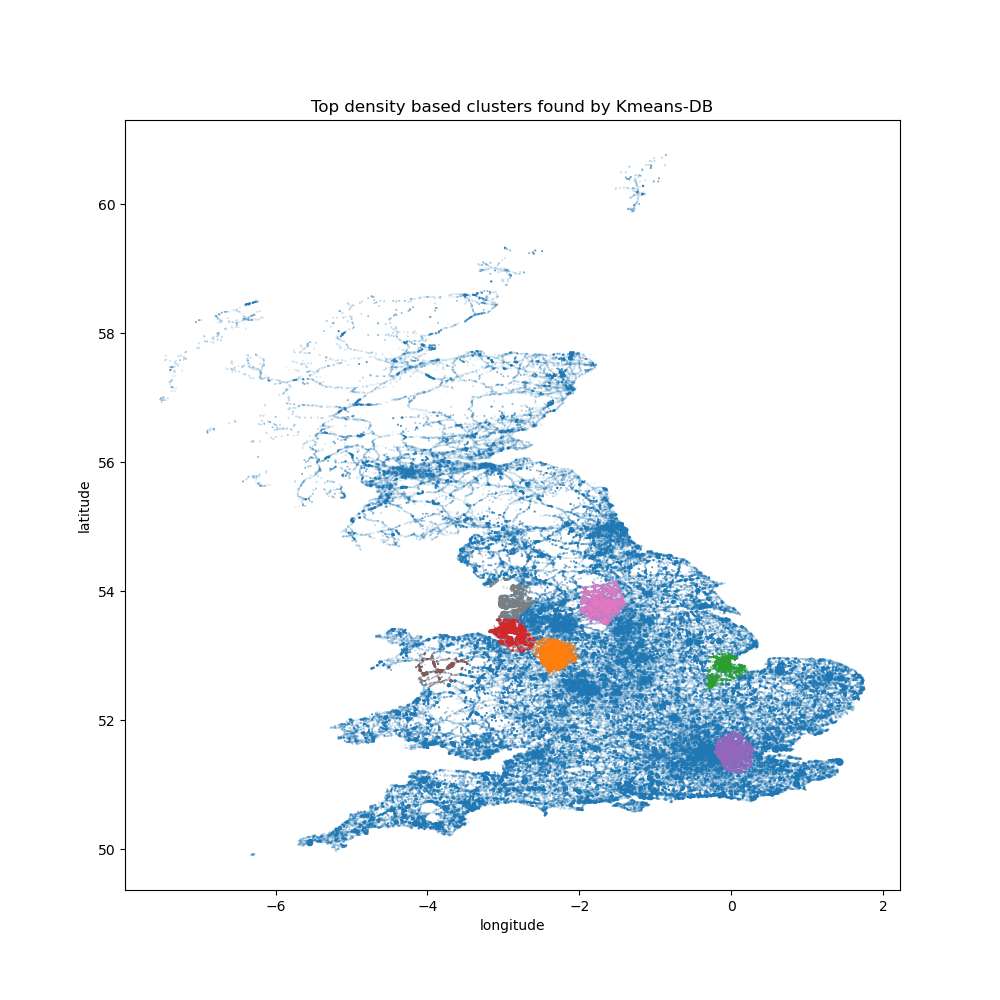

In [272]:
%matplotlib notebook
#plot results
fig = plt.figure(figsize=(10,10))
plt.scatter(locations['Longitude'], locations['Latitude'], s=locations['counts']/locations['weight']*10)
for i in topfive:
    points = locations[km.labels_==i]
    plt.scatter(points['Longitude'], points['Latitude'], s=points['counts']/points['weight']*10)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Top density based clusters found by Kmeans-DB')
plt.show()

In [258]:
np.mean(locations['counts']/locations['weight']) #this number was used in the report

0.01110617638813935